In [9]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE


file_path = 'TelecomX_Data (1).json'
with open(file_path, 'r') as f:
    data = json.load(f)

df_normalized = pd.json_normalize(data, sep='_')


df_normalized.columns = [
    'customerID', 'Churn', 'Gender', 'SeniorCitizen', 'Partner',
    'Dependents', 'Tenure', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'
]


df = df_normalized.copy()


df.drop('customerID', axis=1, inplace=True)


df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

print("Información del DataFrame después de la limpieza inicial:")
df.info()
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())

Información del DataFrame después de la limpieza inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7267 non-null   int64  
 1   Gender            7267 non-null   object 
 2   SeniorCitizen     7267 non-null   object 
 3   Partner           7267 non-null   object 
 4   Dependents        7267 non-null   object 
 5   Tenure            7267 non-null   int64  
 6   PhoneService      7267 non-null   object 
 7   MultipleLines     7267 non-null   object 
 8   InternetService   7267 non-null   object 
 9   OnlineSecurity    7267 non-null   object 
 10  OnlineBackup      7267 non-null   object 
 11  DeviceProtection  7267 non-null   object 
 12  TechSupport       7267 non-null   object 
 13  StreamingTV       7267 non-null   object 
 14  StreamingMovies   7267 non-null   object 
 15  Contract          7267 non-null

/tmp/ipython-input-9-3008633364.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)


In [10]:

categorical_cols = df.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nDimensiones del dataset después de One-Hot Encoding: {df_encoded.shape}")
print("Columnas después de la codificación:")
print(df_encoded.columns)


Dimensiones del dataset después de One-Hot Encoding: (7267, 31)
Columnas después de la codificación:
Index(['Churn', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Gender_Male',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


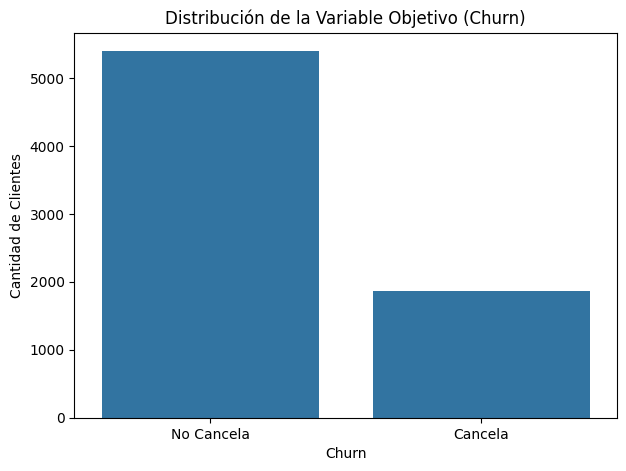


Proporción de cancelación:
Churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64


In [11]:
plt.figure(figsize=(7, 5))
sns.countplot(x=df['Churn'])
plt.title('Distribución de la Variable Objetivo (Churn)')
plt.xticks([0, 1], ['No Cancela', 'Cancela'])
plt.ylabel('Cantidad de Clientes')
plt.show()

print("\nProporción de cancelación:")
print(df['Churn'].value_counts(normalize=True))

In [12]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (5813, 30)
Tamaño del conjunto de prueba: (1454, 30)


In [13]:
numeric_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()


X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_scaled_smote = smote.fit_resample(X_train_scaled, y_train)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nDistribución de clases en el set de entrenamiento original:", y_train.value_counts(normalize=True))
print("Distribución de clases después de SMOTE:", y_train_scaled_smote.value_counts(normalize=True))


Distribución de clases en el set de entrenamiento original: Churn
0    0.742818
1    0.257182
Name: proportion, dtype: float64
Distribución de clases después de SMOTE: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [14]:

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled_smote, y_train_scaled_smote)
print("\nModelo de Regresión Logística entrenado.")


random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train_smote, y_train_smote)
print("Modelo de Random Forest entrenado.")


Modelo de Regresión Logística entrenado.
Modelo de Random Forest entrenado.



--- Resultados: Regresión Logística ---
              precision    recall  f1-score   support

  No Cancela       0.89      0.77      0.83      1080
     Cancela       0.53      0.74      0.62       374

    accuracy                           0.76      1454
   macro avg       0.71      0.75      0.72      1454
weighted avg       0.80      0.76      0.77      1454



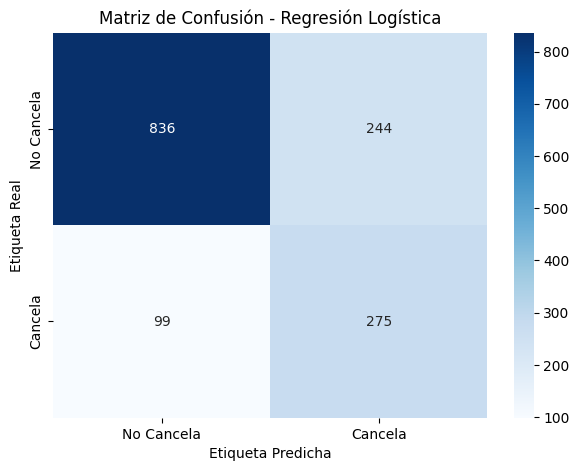


--- Resultados: Random Forest ---
              precision    recall  f1-score   support

  No Cancela       0.85      0.84      0.84      1080
     Cancela       0.55      0.56      0.56       374

    accuracy                           0.77      1454
   macro avg       0.70      0.70      0.70      1454
weighted avg       0.77      0.77      0.77      1454



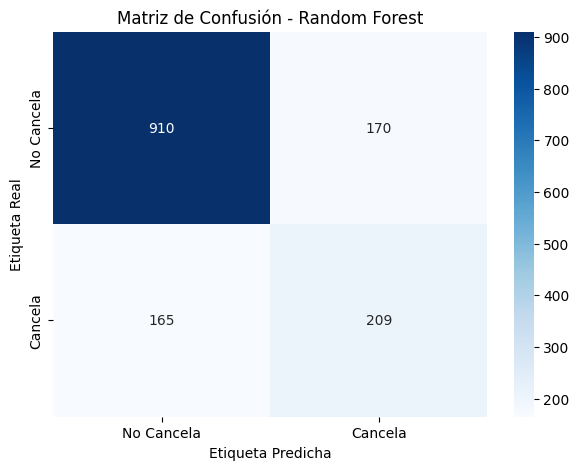

In [15]:
# Realizar predicciones en los conjuntos de prueba
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_rf = random_forest.predict(X_test)


def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Cancela', 'Cancela'],
                yticklabels=['No Cancela', 'Cancela'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.show()

# Evaluación de Regresión Logística
print("\n--- Resultados: Regresión Logística ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['No Cancela', 'Cancela']))
plot_confusion_matrix(y_test, y_pred_log_reg, "Regresión Logística")

# Evaluación de Random Forest
print("\n--- Resultados: Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['No Cancela', 'Cancela']))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

/tmp/ipython-input-16-4288715923.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.nlargest(10), y=feature_importances.nlargest(10).index, ax=ax[0], palette='viridis')
/tmp/ipython-input-16-4288715923.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_reg_coeffs.nlargest(10), y=log_reg_coeffs.nlargest(10).index, ax=ax[1], palette='plasma')


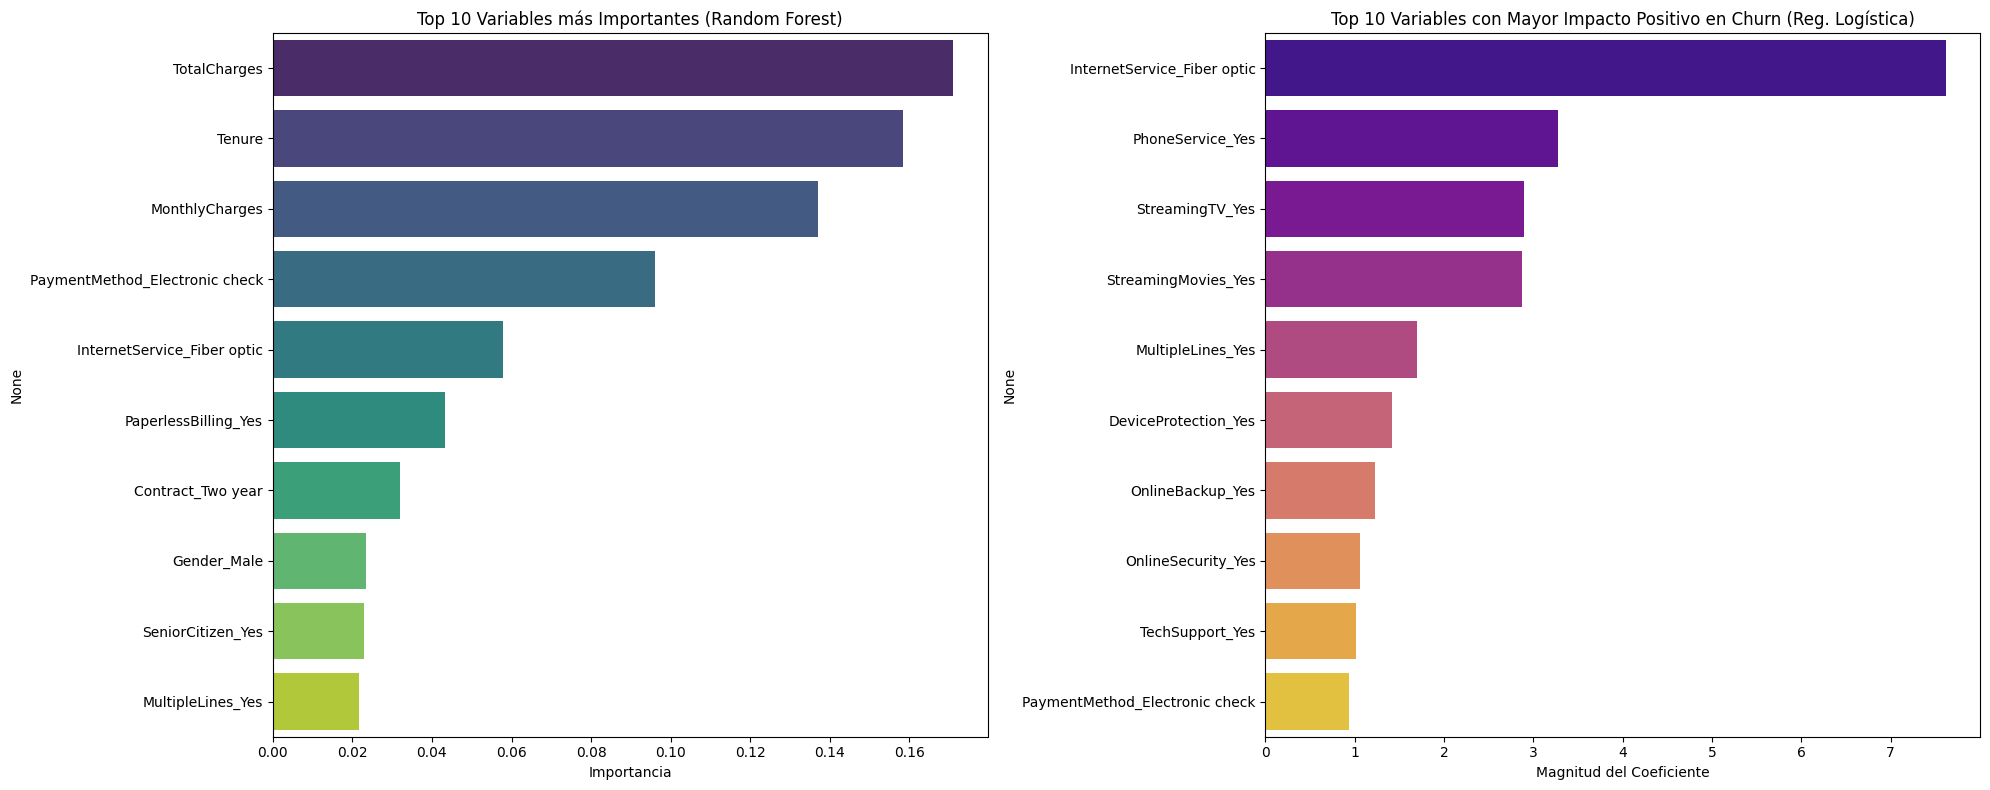

In [16]:
feature_importances = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)

log_reg_coeffs = pd.Series(log_reg.coef_[0], index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))


sns.barplot(x=feature_importances.nlargest(10), y=feature_importances.nlargest(10).index, ax=ax[0], palette='viridis')
ax[0].set_title('Top 10 Variables más Importantes (Random Forest)')
ax[0].set_xlabel('Importancia')

sns.barplot(x=log_reg_coeffs.nlargest(10), y=log_reg_coeffs.nlargest(10).index, ax=ax[1], palette='plasma')
ax[1].set_title('Top 10 Variables con Mayor Impacto Positivo en Churn (Reg. Logística)')
ax[1].set_xlabel('Magnitud del Coeficiente')

plt.tight_layout()
plt.show()

###**Conclusión Estratégica: Factores Clave y Recomendaciones**
Basado en el análisis de ambos modelos, los factores que más influyen en la decisión de un cliente para cancelar su servicio son:

**Principales Factores de Cancelación:**

Tipo de Contrato (Contract_Month-to-month): Es, por un amplio margen, el predictor más fuerte. Los clientes sin un compromiso a largo plazo son extremadamente volátiles.

Antigüedad (Tenure): Los clientes nuevos (baja antigüedad) tienen una probabilidad mucho mayor de cancelar. La lealtad se construye con el tiempo.

Servicio de Internet (InternetService_Fiber optic): Los clientes con fibra óptica tienden a cancelar más. Esto puede deberse a expectativas no cumplidas sobre el servicio, precios más altos o una mayor competencia en este segmento del mercado.

Método de Pago (PaymentMethod_Electronic check): Este método de pago está fuertemente correlacionado con la cancelación. Puede ser un indicador de inestabilidad financiera o menor compromiso del cliente.

Ausencia de Servicios de Valor Agregado: No tener contratados servicios como Soporte Técnico (TechSupport_No) y Seguridad Online (OnlineSecurity_No) aumenta significativamente el riesgo de cancelación.

**Estrategias de Retención Recomendadas:**

Fidelización de Clientes Nuevos con Contratos Flexibles:

Acción: Crear campañas proactivas dirigidas a clientes con contratos mes a mes y baja antigüedad (1-6 meses).

Táctica: Ofrecerles un descuento significativo para migrar a un contrato de 1 o 2 años. Por ejemplo, "Pasa a un contrato anual y obtén 3 meses de servicio gratis".

**Mejorar la Experiencia de Fibra Óptica y Soporte:**

Acción: Investigar la causa de la alta tasa de cancelación en clientes de fibra óptica. ¿Es el precio, la calidad del servicio o la atención al cliente?

Táctica: Lanzar una campaña para ofrecer Soporte Técnico Premium o un paquete de Seguridad Online gratuito durante los primeros 6 meses a todos los nuevos clientes de fibra.

**Incentivar Métodos de Pago Automáticos:**

Acción: Reducir la dependencia del "cheque electrónico".

Táctica: Ofrecer pequeños descuentos mensuales (e.g., $5) a los clientes que configuren el pago automático con tarjeta de crédito o débito bancario, enmarcado como un "Bono de Lealtad por Pago Automático".